In [16]:
import os, sys, time, resource, re, gc, shutil
from django.db.models import Count
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django



from scipy.spatial import ConvexHull

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from utils.text import *
from tmv_app.tasks import *
from scoping.models import *
from tmv_app.models import *
matplotlib.rcParams["figure.figsize"] = [7.2,4.5]
matplotlib.rcParams['axes.labelsize'] = 7 
matplotlib.rcParams['xtick.labelsize'] = 5
matplotlib.rcParams['ytick.labelsize'] = 5 


q = Query.objects.get(pk=2880)

docs = Doc.objects.filter(query=q,PY__lt=2018,PY__gt=1980)

In [2]:
docs_an = docs.values('PY').annotate(
    n_docs = Count('id', distinct=True),
    n_journals = Count('wosarticle__so', distinct=True),
    n_authors = Count('docauthinst__AU', distinct=True),
    n_keywords = Count('wosarticle__de', distinct=True)
)

df = pd.DataFrame.from_dict(list(docs_an))

df.tail()

,PY,n_authors,n_docs,n_journals,n_keywords
32,2013,107370,39823,6800,19130
33,2014,117994,42850,7018,21037
34,2015,123812,43712,7125,23294
35,2016,128430,44394,6582,26196
36,2017,147563,51153,7481,28423


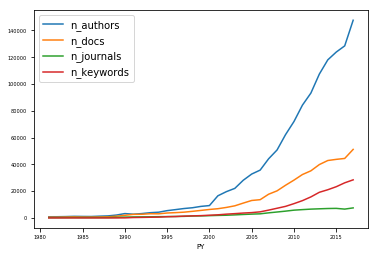

In [3]:
plt.close()
pdf = df.set_index('PY')
pdf.plot()

plt.show()

In [4]:
def get_year_words(row,docs):
    py = row['PY']
    docs = docs.filter(PY=py)
    abstracts, docsizes, ids, citations = proc_docs(docs, stoplist, False, False)
    try:
        count_vectorizer = CountVectorizer(
            min_df=5,
            max_features=100000,
            ngram_range=(1,1),
            stop_words=stoplist
        )
        tfidf = count_vectorizer.fit_transform(abstracts).shape[1]
    except:
        tfidf = 0
    return tfidf
    
abstracts = get_year_words({'PY':1990},docs)
df['n_words'] = df.apply(lambda x: get_year_words(x,docs),axis=1)

df.tail()

,PY,n_authors,n_docs,n_journals,n_keywords,n_words
32,2013,107370,39823,6800,19130,25134
33,2014,117994,42850,7018,21037,26350
34,2015,123812,43712,7125,23294,27125
35,2016,128430,44394,6582,26196,27370
36,2017,147563,51153,7481,28423,29479


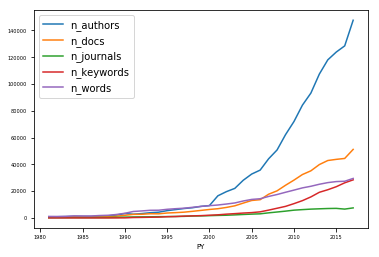

In [5]:
plt.close()
pdf = df.set_index('PY')
pdf.plot()
plt.savefig('../plots/vs_{}.png'.format(q.title))
plt.show()

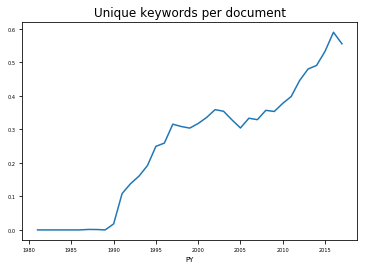

In [6]:
df['key_docs'] = df['n_keywords']/df['n_docs']

plt.close()
pdf = df.set_index('PY')['key_docs']
pdf.plot()
plt.title("Unique keywords per document")
plt.savefig('../plots/scaled_variety_{}.png'.format(q.title))

plt.show()

In [7]:
df.to_csv('../data/vs_{}.csv'.format(q.title),index=False)

  require(slam)
  df[,"z"] <- df[,field]
  df <- df %>%
    ungroup() %>%
    filter(PY >=y1 & PY <=y2 & PY%%5==0 & !is.na(z)) %>%
    group_by(z)
  
  totals <- df %>%
    mutate(
      v1 = n[which.min(PY)],
      v2 = n[which.max(PY)],
      Growth = round(((v2/v1)^(1/(y2-y1))-1)*100) ,
      period=paste0("Total: ",y1,"-",y2)
    ) %>%
    select(period,z,Growth) 
  
  df_sum <- df %>%
    mutate(
      change = n- lag(n),
      Growth = round(((n/lag(n))^(1/(PY-lag(PY)))-1)*100),
      period = paste0(lag(PY),"-",PY)
    ) %>%
    filter(!is.na(change)) %>%
    select(period,z,Growth)

In [8]:
docs = df[['PY','n_docs']]
docs['lower_bound'] = docs['n_docs']
docs['upper_bound'] = docs['n_docs']

def growth_rate(df,v,nyears=0):
    if nyears > 0:
        df = df[df['PY']>df.max()['PY']-nyears]
    y1 = df.min()['PY']
    y2 = df.max()['PY']
    v1 = df[df['PY']==y1][v].iloc[0]
    v2 = df[df['PY']==y2][v].iloc[0]
    g = round(((v2/v1)**(1/(y2-y1))-1)*100,2)
    return g

#docs.head()

grate = growth_rate(df,'n_docs',15)
print(grate)

docs.tail()

for y in [2017,2018,2019,2020,2021]:
    r = pd.DataFrame(data={
        'PY':y,
        'lower_bound': docs[docs['PY']==y-1]['lower_bound'],
        'upper_bound': docs[docs['PY']==y-1]['upper_bound'].iloc[0]*(1+grate/100)
    })
    docs = docs.append(r)
    
docs.tail()

docs.to_csv('../data/PY_docs_projections_{}.csv'.format(q.title),index=False)

13.19


/home/galm/software/django/tmvenv/lib/python3.4/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmvenv/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
docs

,PY,lower_bound,n_docs,upper_bound
0,1981,558,558.0,558.000000
1,1982,547,547.0,547.000000
2,1983,641,641.0,641.000000
3,1984,747,747.0,747.000000
4,1985,624,624.0,624.000000
5,1986,618,618.0,618.000000
6,1987,703,703.0,703.000000
7,1988,843,843.0,843.000000
8,1989,1299,1299.0,1299.000000
9,1990,1953,1953.0,1953.000000


ValueError: incompatible sizes: argument 'height' must be length 1 or scalar

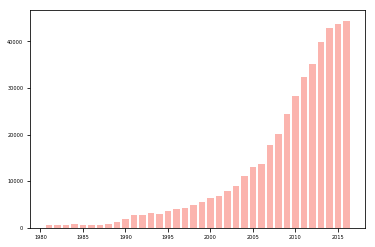

In [10]:
for y, group in docs.groupby('PY'):
    plt.bar(y,group['lower_bound'],color='#fbb4ae')
    if group['upper_bound'].iloc[0] > group['lower_bound'].iloc[0]:
        plt.bar(y,group['upper_bound'],color='#fbb4ae',alpha=0.5)

In [11]:
def sum_field(row,df,col):
    yrange = list(range(row['start'],row['end']+1))
    df = df[df['PY'].isin(yrange)]
    return df.sum()[col]


## Docs by assessment period
aps = AR.objects.all().order_by('ar')
ardf = pd.DataFrame.from_dict(list(aps.values('ar','name','start','end')))
ardf['n_docs_lower'] = ardf.apply(lambda x: sum_field(x,docs,'lower_bound'),axis=1)
ardf['n_docs_upper'] = ardf.apply(lambda x: sum_field(x,docs,'upper_bound'),axis=1)
ardf.tail()

ardf.to_csv('../data/ar_docs_projections_{}.csv'.format(q.title),index=False)

In [12]:
ardf = pd.DataFrame.from_dict(list(aps.values('ar','name','start','end')))

for c in df.columns:
    if c not in ["PY","key_docs"]:
        ardf[c] = ardf.apply(lambda x: sum_field(x,df,c),axis=1)
        
        
df['key_docs'] = ardf['n_keywords']/ardf['n_docs']        
ardf.head()

ardf.to_csv('../data/vs_by_ar_{}.csv'.format(q.title),index=False)

In [13]:
wosqs = Query.objects.filter(project_id=23,database="WoS").exclude(title__in=["haunschild","bla","ipcc","energy_policy"])
scopusqs = Query.objects.filter(project_id=23,database="scopus").exclude(title__in=["scopus 1990"])
wosqs

<QuerySet [<Query: wos_all>, <Query: wos_2017>]>

In [17]:
docs = Doc.objects.filter(query=q,PY__lt=2018,PY__gt=1980)
doc_counts = []
for py in range(1981,2018):
    print(py)
    pydocs = docs.filter(PY=py)
    wosdocs = set(pydocs.filter(query__in=wosqs).values_list('id',flat=True))
    scopusdocs = set(pydocs.filter(query__in=scopusqs).values_list('id',flat=True))
    wos = len(wosdocs)
    scopus = len(scopusdocs)
    both = len(wosdocs & scopusdocs)
    wos_only = len(wosdocs - scopusdocs)
    scopus_only = len(scopusdocs - wosdocs)
    doc_counts.append({
        'wos':wos,
        'scopus': scopus,
        'both': both,
        'wos_only': wos_only,
        'scopus_only': scopus_only
    })

1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [18]:
wsdocs = pd.DataFrame.from_dict(doc_counts)
wsdocs['PY'] = list(range(1981,2018))
wsdocs.tail()

,both,scopus,scopus_only,wos,wos_only,PY
32,20595,34427,13832,25991,5396,2013
33,21626,36405,14779,28071,6445,2014
34,22862,36057,13195,30517,7655,2015
35,25950,36645,10695,33699,7749,2016
36,25083,40256,15173,35980,10897,2017


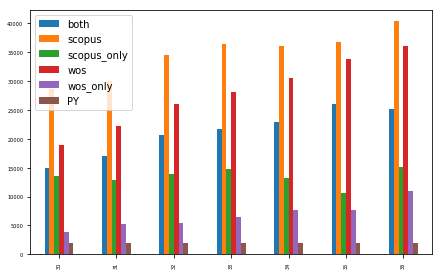

In [19]:
wsdocs[wsdocs['PY']>2010].plot.bar()

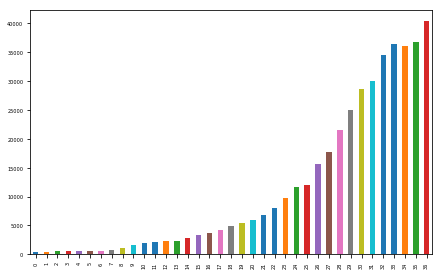

In [20]:
wsdocs['scopus'].plot.bar()

In [21]:
wsdocs['total'] = wsdocs['both'] + wsdocs['wos_only'] + wsdocs['scopus_only']
wsdocs['scopus_share'] = wsdocs['scopus'] / wsdocs['total']
wsdocs['wos_share'] = wsdocs['wos'] / wsdocs['total']
wsdocs.tail(20)

,both,scopus,scopus_only,wos,wos_only,PY,total,scopus_share,wos_share
17,2451,4205,1754,3167,716,1998,4921,0.854501,0.643568
18,2810,4827,2017,3589,779,1999,5606,0.861042,0.640207
19,3111,5504,2393,3915,804,2000,6308,0.872543,0.620640
20,3420,5864,2444,4430,1010,2001,6874,0.853070,0.644457
21,3729,6813,3084,4741,1012,2002,7825,0.870671,0.605879
22,4136,7986,3850,5175,1039,2003,9025,0.884875,0.573407
23,4634,9813,5179,5887,1253,2004,11066,0.886770,0.531990
24,5357,11635,6278,6741,1384,2005,13019,0.893694,0.517782
25,5963,12037,6074,7537,1574,2006,13611,0.884358,0.553743
26,7495,15692,8197,9489,1994,2007,17686,0.887255,0.536526


In [22]:
wsdocs['n_docs_estimate'] = wsdocs['total']
wsdocs.loc[wsdocs['PY']>2013,'n_docs_estimate'] = wsdocs[wsdocs['PY']>2013]['wos']/0.65

wsdocs.tail()

,both,scopus,scopus_only,wos,wos_only,PY,total,scopus_share,wos_share,n_docs_estimate
32,20595,34427,13832,25991,5396,2013,39823,0.864500,0.652663,39823.000000
33,21626,36405,14779,28071,6445,2014,42850,0.849592,0.655099,43186.153846
34,22862,36057,13195,30517,7655,2015,43712,0.824876,0.698138,46949.230769
35,25950,36645,10695,33699,7749,2016,44394,0.825449,0.759089,51844.615385
36,25083,40256,15173,35980,10897,2017,51153,0.786972,0.703380,55353.846154


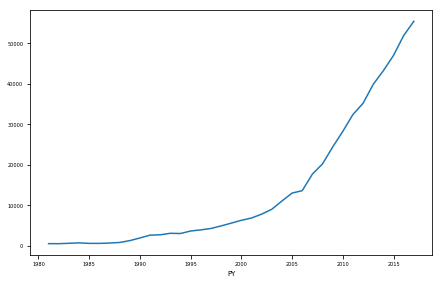

In [23]:
pdf = wsdocs.set_index('PY')
pdf['n_docs_estimate'].plot()

In [24]:
wsdocs['n_docs'] = wsdocs['n_docs_estimate']
docs = wsdocs[['PY','n_docs','wos']].copy()
docs.loc[:,'lower_bound'] = docs.loc[:,'n_docs']
docs['upper_bound'] = docs['n_docs']

def growth_rate(df,v,nyears=0):
    if nyears > 0:
        df = df[df['PY']>df.max()['PY']-nyears]
    y1 = df.min()['PY']
    y2 = df.max()['PY']
    v1 = df[df['PY']==y1][v].iloc[0]
    v2 = df[df['PY']==y2][v].iloc[0]
    g = round(((v2/v1)**(1/(y2-y1))-1)*100,2)
    return g


grate = growth_rate(docs,'n_docs',15)
print(grate)

docs.tail()

for y in [2018,2019,2020]:
    r = pd.DataFrame(data={
        'PY':y,
        'lower_bound': docs[docs['PY']==y-1]['lower_bound'],
        'upper_bound': docs[docs['PY']==y-1]['upper_bound'].iloc[0]*(1+grate/100)
    })
    docs = docs.append(r)
    
docs.tail()

docs.to_csv('../data/PY_docs_projections_wos_scopus_{}.csv'.format(q.title),index=False)

13.83


In [25]:
def sum_field(row,df,col):
    yrange = list(range(row['start'],row['end']+1))
    df = df[df['PY'].isin(yrange)]
    return df.sum()[col]

def get_ipcc_refs(x):
    ar = AR.objects.get(name=x['name'])
    iprs = IPCCRef.objects.filter(
        wg__ar=ar,
        year__gte=ar.start
    ).distinct()
    return iprs.count()
    
## Docs by assessment period
aps = AR.objects.all().order_by('ar')
ardf = pd.DataFrame.from_dict(list(aps.values('ar','name','start','end')))
ardf['n_docs_lower'] = ardf.apply(lambda x: sum_field(x,docs,'lower_bound'),axis=1)
ardf['n_docs_upper'] = ardf.apply(lambda x: sum_field(x,docs,'upper_bound'),axis=1)
ardf['wos'] = ardf.apply(lambda x: sum_field(x,docs,'wos'),axis=1)
ardf['ipcc_citations'] = ardf.apply(lambda x: get_ipcc_refs(x),axis=1)

ardf.tail()

,ar,end,name,start,n_docs_lower,n_docs_upper,wos,ipcc_citations
2,2,1994,AR2,1990,13499.000000,13499.00000,7623.0,5070
3,3,2000,AR3,1996,25074.000000,25074.00000,16395.0,9614
4,4,2006,AR4,2001,61420.000000,61420.00000,34511.0,13003
5,5,2013,AR5,2007,197858.000000,197858.00000,117766.0,27719
6,6,9998,AR6,2014,363395.384615,413709.41856,128267.0,0


In [26]:
ardf['ipcc_ratio'] = ardf['ipcc_citations'] / ardf['n_docs_lower']
ardf['ipcc_ratio_wos'] = ardf['ipcc_citations'] / ardf['wos']
ardf.tail(6)

,ar,end,name,start,n_docs_lower,n_docs_upper,wos,ipcc_citations,ipcc_ratio,ipcc_ratio_wos
1,1,1989,AR1,1988,2142.000000,2142.00000,625.0,758,0.353875,1.212800
2,2,1994,AR2,1990,13499.000000,13499.00000,7623.0,5070,0.375583,0.665092
3,3,2000,AR3,1996,25074.000000,25074.00000,16395.0,9614,0.383425,0.586398
4,4,2006,AR4,2001,61420.000000,61420.00000,34511.0,13003,0.211706,0.376778
5,5,2013,AR5,2007,197858.000000,197858.00000,117766.0,27719,0.140095,0.235374
6,6,9998,AR6,2014,363395.384615,413709.41856,128267.0,0,0.000000,0.000000


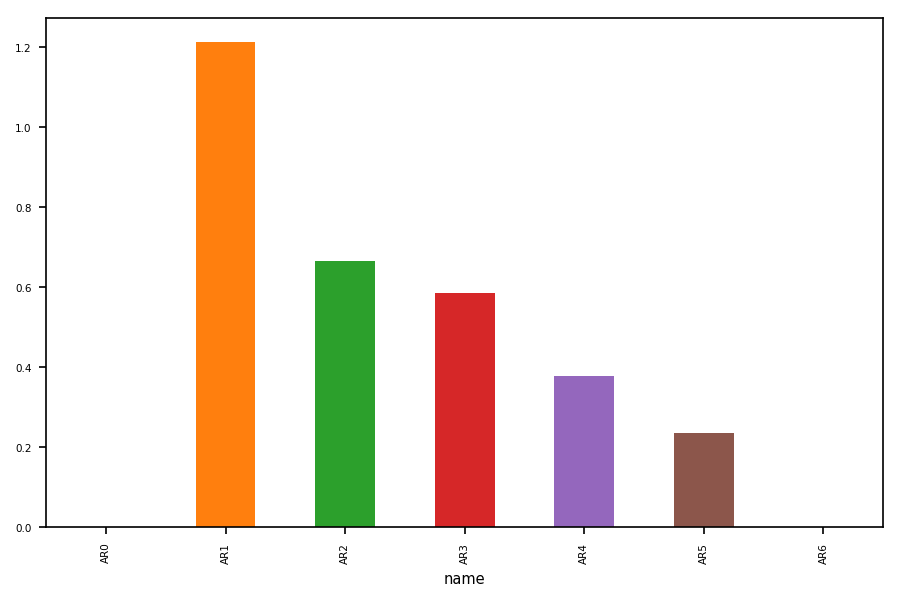

In [27]:
fig = plt.figure(dpi=150)
ardf.set_index('name')['ipcc_ratio_wos'].plot.bar()

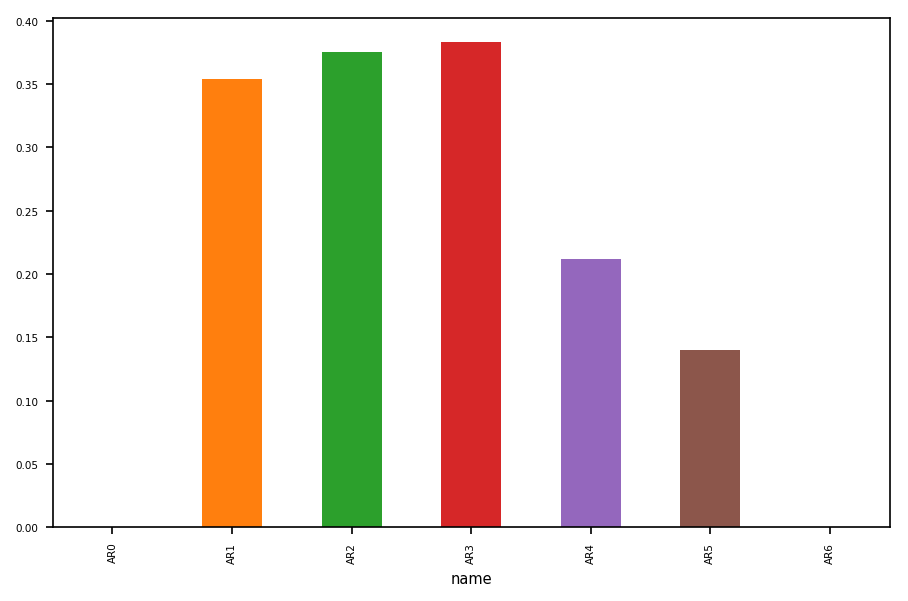

In [28]:
fig = plt.figure(dpi=150)
ardf.set_index('name')['ipcc_ratio'].plot.bar()

In [29]:
ar1 = AR.objects.get(name="AR1")
ar1.start=1988
ar1.end=1989
ar1.save()

ar2 = AR.objects.get(name="AR2")
ar2.start=1990
ar2.end=1994
ar2.save()

ar3 = AR.objects.get(name="AR3")
ar3.start=1996
ar3.end=2000
ar3.save()

ar4 = AR.objects.get(name="AR4")
ar4.start=2001
ar4.end=2006
ar4.save()

ar5 = AR.objects.get(name="AR5")
ar5.start=2007
ar5.save()



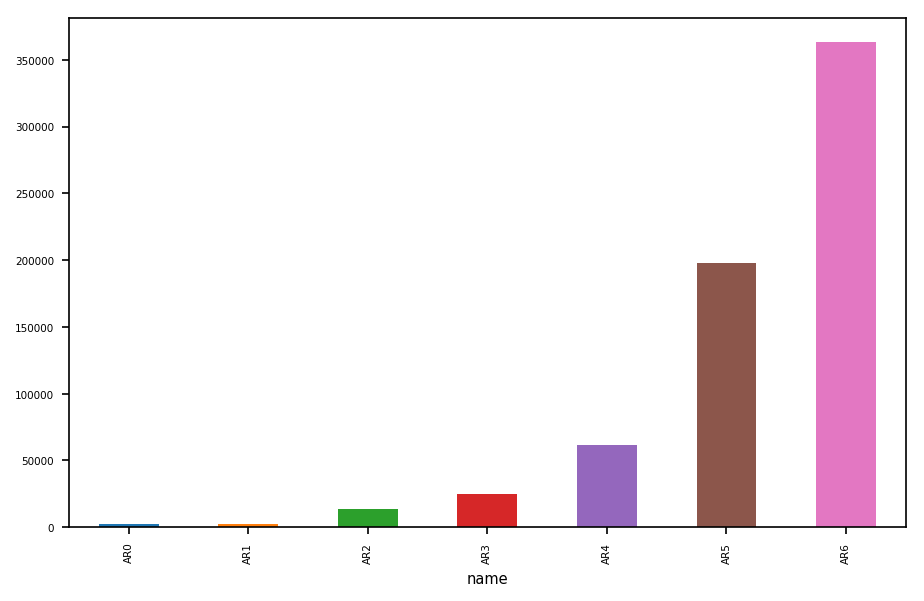

In [30]:
fig = plt.figure(dpi=150)
ardf.set_index('name')['n_docs_lower'].plot.bar()

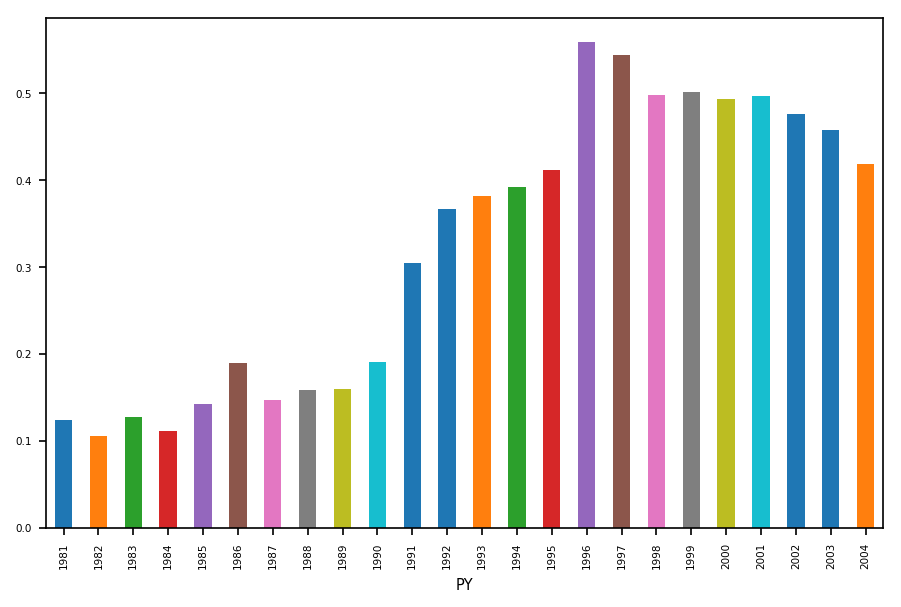

In [31]:
fig = plt.figure(dpi=150)
wsdocs['both_share'] = wsdocs['both'] / wsdocs['total']
wsdocs[wsdocs['PY']<2005].set_index('PY')['both_share'].plot.bar()

In [33]:
wsdocs['n_docs'].sum()

505432.8461538461